In [3]:
from dime import *
from config_sim import *
import numpy as np
import matplotlib.pyplot as plt

In [94]:
n_lat=180
n_lon=360
r_deg=10
lat_deg=-60
lon_deg=0
r1_deg=5
lat1_deg=0
lon1_deg=60

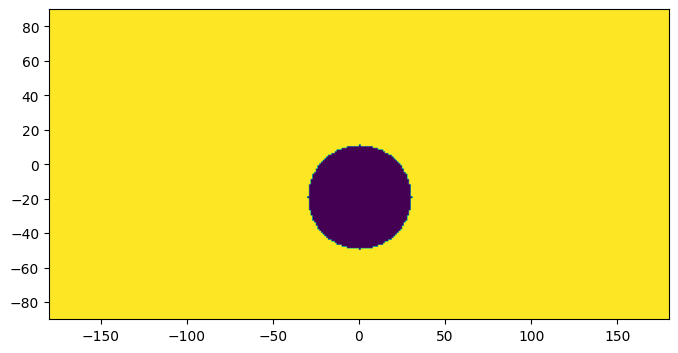

In [43]:
fakemap = np.ones((n_lat, n_lon))
x, y = np.meshgrid(np.linspace(-n_lon/2, n_lon/2-1, n_lon), np.linspace(-n_lat/2, n_lat/2-1, n_lat))
fakemap[np.sqrt((y-lat_deg)**2 + (x-lon_deg)**2) <= r_deg] = 0.9 # default spot at lon=0
plt.figure(figsize=(8,6))
plt.imshow(fakemap, origin='lower', extent=(-180, 180, -90, 90));

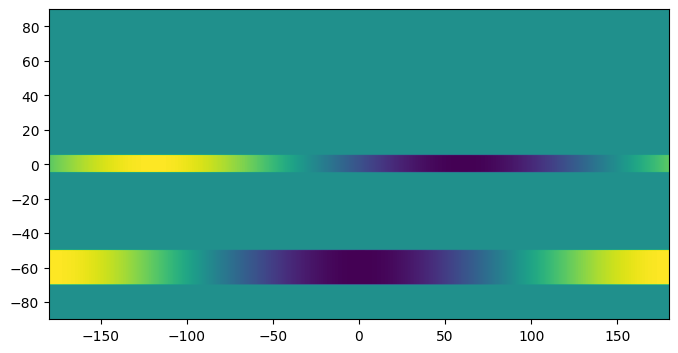

In [97]:
contrast = 0.8
amp = 1. - contrast
fakemap = np.ones((n_lat, n_lon))
band_ind = np.s_[90+lat_deg-r_deg:90+lat_deg+r_deg]
fakemap[band_ind] += amp * np.sin((x[band_ind]-lon_deg-90) * np.pi/180)
band1_ind = np.s_[90+lat1_deg-r1_deg:90+lat1_deg+r1_deg]
fakemap[band1_ind] += amp * np.sin((x[band1_ind]-lon1_deg-90) * np.pi/180)

plt.figure(figsize=(8,6))
plt.imshow(fakemap, origin='lower', extent=(-180, 180, -90, 90));

In [70]:
import paths
fakemap = str(paths.data / 'modelmaps/SPOT.png')

In [147]:
img = np.loadtxt(paths.data/'modelmaps/gcm.txt')

In [148]:
img = zoom(img, (180/img.shape[0], 360/img.shape[1]), mode='nearest')
img.shape

(180, 360)

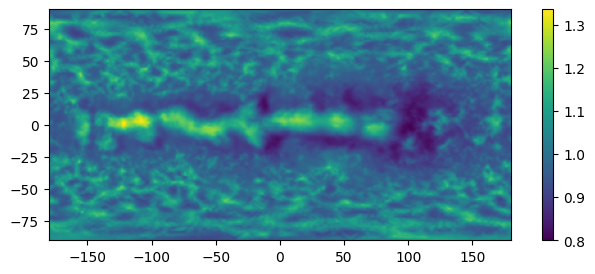

In [151]:
lon_deg = 100
img /= np.median(img)
diff = 1 - img
ampold = diff.max()
amp = 1 - contrast
diffnew = diff * amp / ampold
fakemap = 1 - diffnew
fakemap = np.roll(fakemap, shift=int(lon_deg), axis=1)
plt.figure(figsize=(8,3))
plt.imshow(fakemap, origin='lower', extent=(-180, 180, -90, 90))
plt.colorbar();

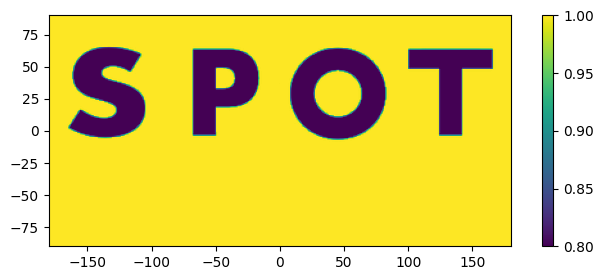

In [162]:
contrast = 0.8
amp=1-contrast
img = plt.imread(paths.data/'modelmaps/SPOT.png')
img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
img = zoom(img[::-1], (180/img.shape[0], 360/img.shape[1]), mode='nearest')
img /= np.median(img)
diff = 1. - img
diffnew = diff * amp / diff.max()
fakemap = 1. - diffnew
plt.figure(figsize=(8,3))
plt.imshow(fakemap, origin='lower', extent=(-180, 180, -90, 90))
plt.colorbar();

In [160]:
fakemap.max()

0.9999769234317623

In [158]:
img.min()

0.1333200069531798

In [154]:
img.shape

(180, 360, 3)

In [1]:
import paths
import os
from dime import DopplerImaging, load_data_from_pickle
from config import load_config

instru = "IGRINS"
target = "W1049B"
band = "H"
savedir = f"{instru}_{band}_{target}"

params, goodchips, modelspec = load_config(instru, target, band)
model_datafile = paths.data/f'{instru}_{target}_{band}_{modelspec}.pickle'
#goodchips = [1,2,3,4]

wav_nm, template, observed, error = load_data_from_pickle(model_datafile, goodchips)

mapB_H = DopplerImaging(wav_nm, goodchips, params_dict=params)
mapB_H.load_data(observed, template, error)

/Users/xqchen/workspace/maxentropy_doppler_imaging/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded from file /Users/xqchen/workspace/maxentropy_doppler_imaging/data/IGRINS_W1049B_H_t1500g1000f8.pickle.
nobs: 14, nchip: 10, npix: 1848
observed: (14, 10, 1848)
template: (14, 10, 1848)
wav: (10, 1848)
nobs: 14, nchip: 10, npix: 1848
Created equa-area grid of 216 cells, in 12 latitude grids with [ 6 12 17 21 25 27 27 25 21 17 12  6] lontitude cells.


/Users/xqchen/workspace/maxentropy_doppler_imaging/src/ELL_map_class.py:414: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(1. - np.tan(inc)**2 / np.tan(self.corners_latlon[0,ii])**2)
/Users/xqchen/workspace/maxentropy_doppler_imaging/src/ELL_map_class.py:414: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1. - np.tan(inc)**2 / np.tan(self.corners_latlon[0,ii])**2)


chip 0


/Users/xqchen/workspace/maxentropy_doppler_imaging/venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


chip 1
chip 2
chip 3
chip 4
chip 5
chip 16
chip 17
chip 18
chip 19


/Users/xqchen/workspace/maxentropy_doppler_imaging/venv/lib/python3.9/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/xqchen/workspace/maxentropy_doppler_imaging/venv/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


metric: -10691.49, chisq: 112.04, entropy: 5.37


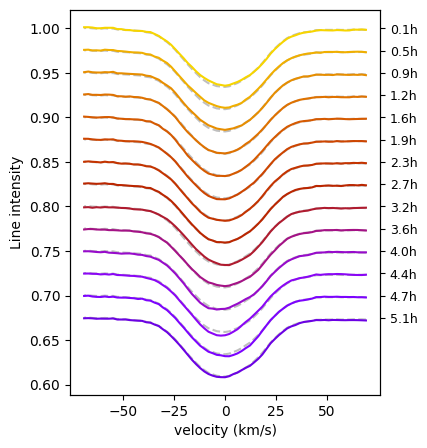

In [2]:
mapB_H.make_lsd_profile(modelspec, plot_lsd_profiles=True, plot_deviation_map=False)
mapB_H.solve(create_obs_from_diff=True, solver='scipy')

metric: -10691.49, chisq: 112.04, entropy: 5.37


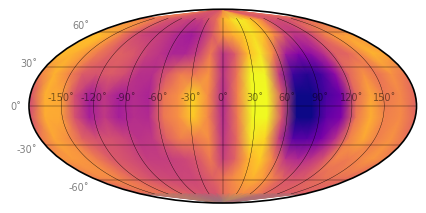

In [5]:
mapB_H.solve(create_obs_from_diff=True, solver='scipy')
mapB_H.plot_mollweide_map(vmin=85, vmax=110)